In [3]:
#TODO: CREATE the ground truth DATASET for SALIENCY MODEL.
        #for a given timestamp: a) get saliency maps b) get associated image
#INPUT: ds, topic, timestamp
#OUTPUT: a pair of image and saliency map


#indataset ---> our saliency model ----> outdataset
#this step is to create INDATASET

import pickle
import imp
import numpy as np
import cv2
from matplotlib import pyplot as plt

#import saliency_ds_lib
import header_saliency_ds as header
import headoren_sal_corr_helper


imp.reload(header)
imp.reload(headoren_sal_corr_helper)
#imp.reload(saliency_ds_lib)
%matplotlib inline


fps_dict = header.fps_dict
tdict = header.topic_dict
try:
    saldat_dict
except:
    saldat_dict = {}

In [4]:


#now, you go fetch them data for m!
#getting saliency data
try:
    vector_ds_dict
except:
    vector_ds_dict = {}


MODE = 'groundtruth'#generating dataset from groundtruth
helper_salgt = headoren_sal_corr_helper.HeadorenSalCorrHelper(saldat_dict, vector_ds_dict, MODE)

NOTE, for predicted sal, will use: ./data/pano-saliency-pred152-step002-iter891/saliency_ds{}_topic{}
LOG: initilize headoren
LOG: loading topic dict
LOG: initilize saldat dict & vector ds dict
LOG: initilize mean salmap
LOG: initilize sactivity dict


In [5]:
144/45, 256/80

(3.2, 3.2)

In [6]:
import header_saliency_ds as header
class SalnetDatasetGenerator:
    def __init__(self, tdict, sal_dict, fps_dict, MODE):
        #GOAL: prepare dataset to train saliency predictor (resnet model)
        #TODO: create ds_full file 
        #INPUT: pano-saliency folder & pano-vid/frames folder
        #OUTPUT: ds_full file storing ALL (image & fixation input) & saliency ground truth
                #ds_train_step file storing file, with steps
        self.FILEPATH_VIDEO = './data/pano-videos'
        self.FILEPATH_SALIENCY = '../hmd-observe-video-prediction/data/pano-saliency-merge'
        
        self.tdict = tdict
        self.saldat_dict = sal_dict
        self.vector_ds_dict = {}
        self.fps_dict = fps_dict
        self.helper_salgt = headoren_sal_corr_helper.HeadorenSalCorrHelper(self.saldat_dict, self.vector_ds_dict, MODE)
        
    
    def get_image(self, ds, topic, t0, resize=True):
        #handle special case when two names the same
        if ds==3 and topic=='diving':
            topic = 'diving2'
        fps = self.fps_dict[ds][topic]
        frameid = int(t0 * fps)
        frame_filepath = f'{self.FILEPATH_VIDEO}/frames/{topic}_{frameid:04d}.jpg'
        image = plt.imread(frame_filepath)
        if resize==True:
            image = cv2.resize(image, (header.TARGET_IMG_W, header.TARGET_IMG_H))
        return image, frame_filepath   
    
    def find_timeindex(self, t0, t_list):
        #TODO: find the nearest index in the given time list
        #INPUT: target time t0, time_list
        #OUTPUT: the index for t_list
        if t0 < t_list[0]: 
            return 0
        if t0 > t_list[-1]:
            return len(t_list) - 1
        for idx, _ in enumerate(t_list[1:]):
            if t_list[idx] > t0 and t_list[idx-1] <= t0:
                return idx
        print (t0, idx, t_list[idx], t_list[idx-1])
        raise #you should not get here
    
    def get_saliencymap(self, saldat, ds, topic, t0, blur=True, resize=True):
        t_list = [item[0] for item in saldat]
        idx = self.find_timeindex(t0, t_list)
        _, _, salmap = saldat[idx]
        if blur==True:
            salmap = cv2.GaussianBlur(salmap,(header.TARGET_GAUSSIAN_BLUR, header.TARGET_GAUSSIAN_BLUR),0)
        if resize==True:
            salmap = cv2.resize(salmap, (header.TARGET_SAL_W, header.TARGET_SAL_H))
        if ds==3 and topic=='panel':
            h, w = salmap.shape
            d_roll = int(h * 0.08)
            salmap = np.roll(salmap, d_roll, axis=0)
        return salmap
    
    def get_sample(self, ds, topic, t0):
            self.helper_salgt.f_load_saldat_dict(ds, topic)
            saldat = self.helper_salgt.saldat_dict[self.helper_salgt.f_create_key(ds, topic)]
            img, img_fp = self.get_image(ds, topic, t0)
            smap = self.get_saliencymap(saldat, ds, topic, t0)
            return img, smap
        
    def gen_train_dataset(self, step):
        #TODO1: Create trainset for saliency predictor at step
        sal_ds = []
        bpos, epos, step = 4, 60, step
        for ds in self.tdict:
            for topic in self.tdict[ds]:
                k = self.helper_salgt.f_create_key(ds, topic)
                try:
                    for t0 in np.arange(bpos, epos, step):
                        img, smap = self.get_sample(ds, topic, t0)
                        sal_ds.append((t0, img, smap))
                except Exception as e:
                    print (f"Error at :{ds} - {topic} - {t0} - {e}")
                    continue
        pickle.dump(sal_ds, open(f'{self.FILEPATH_SALIENCY}/ds_dcnn_step{step}', 'wb'))
        
    def gen_test_dataset(self):
        #TODO2: Create test set by getting frame at 4.5, 5.5,  ... timestamp
        sal_ds_test = []
        bpos, epos, step = 4.5, 60, 1.0
        for ds in tdict:
            for topic in tdict[ds]:
                k = self.helper_salgt.f_create_key(ds, topic)
                try:
                    for t0 in np.arange(bpos, epos, step):
                        img, smap = self.get_sample(ds, topic, t0)
                        sal_ds_test.append(((ds, topic, t0), img, smap))
                except Exception as e:
                    print (f"Error at :{ds} - {topic} - {t0} - {e}")
                    continue
        pickle.dump(sal_ds_test, open(f'{self.FILEPATH_SALIENCY}/ds_dcnn_test', 'wb'))
    
    def gen_whole_dataset(self):
        tdict = header.topic_dict
        time_dict = {1:{}, 2:{}, 3:{}}
        for ds in tdict:
            for topic in tdict[ds]:
                dat = pickle.load(open(f'{self.FILEPATH_SALIENCY}/saliency_ds{ds}_topic{topic}', 'rb'))
                time_dict[ds][topic] = [item[0] for item in dat]
        salpred_ds =[]
        for ds in self.tdict:
            for topic in self.tdict[ds]:
                k = self.helper_salgt.f_create_key(ds, topic)
                try:
                    for t0 in time_dict[ds][topic]:
                        img, smap = self.get_sample(ds, topic, t0)
                        salpred_ds.append(((ds, topic, t0), img, smap))
                except Exception as e:
                    print (f"Error at :{ds} - {topic} - {t0} - {e}")
                    continue
        pickle.dump(salpred_ds, open(f'{self.FILEPATH_SALIENCY}/ds_full', 'wb'))

In [7]:
fps_dict = header.fps_dict
tdict = header.topic_dict
MODE = 'groundtruth' #NOTE: create saliency dataset for salnet alway use groundtruth
try:
    saldat_dict
except:
    saldat_dict = {}
salnet_datgen = SalnetDatasetGenerator(tdict, saldat_dict, fps_dict, MODE)

NOTE, for predicted sal, will use: ./data/pano-saliency-pred152-step002-iter891/saliency_ds{}_topic{}
LOG: initilize headoren
LOG: loading topic dict
LOG: initilize saldat dict & vector ds dict
LOG: initilize mean salmap
LOG: initilize sactivity dict


In [8]:
salnet_datgen.gen_train_dataset(0.2)

Loading saliency maps for ds: 1 topic: paris at ./data/pano-saliency/saliency_ds1_topicparis
Loading saliency maps for ds: 1 topic: roller at ./data/pano-saliency/saliency_ds1_topicroller
Loading saliency maps for ds: 1 topic: venise at ./data/pano-saliency/saliency_ds1_topicvenise
Loading saliency maps for ds: 1 topic: diving at ./data/pano-saliency/saliency_ds1_topicdiving
Loading saliency maps for ds: 1 topic: timelapse at ./data/pano-saliency/saliency_ds1_topictimelapse
Loading saliency maps for ds: 2 topic: 0 at ./data/pano-saliency/saliency_ds2_topic0
Loading saliency maps for ds: 2 topic: 1 at ./data/pano-saliency/saliency_ds2_topic1
Loading saliency maps for ds: 2 topic: 2 at ./data/pano-saliency/saliency_ds2_topic2
Loading saliency maps for ds: 2 topic: 3 at ./data/pano-saliency/saliency_ds2_topic3
Loading saliency maps for ds: 2 topic: 4 at ./data/pano-saliency/saliency_ds2_topic4
Loading saliency maps for ds: 2 topic: 5part1 at ./data/pano-saliency/saliency_ds2_topic5part1
L

In [9]:
salnet_datgen.gen_test_dataset()

Error at :3 - coaster2 - 27.5 - [Errno 2] No such file or directory: './data/pano-videos/frames/coaster2_1650.jpg'
Loading saliency maps for ds: 3 topic: diving2 at ./data/pano-saliency/saliency_ds3_topicdiving2
Error at :3 - diving2 - 4.5 - [Errno 2] No such file or directory: './data/pano-saliency/saliency_ds3_topicdiving2'


In [10]:
salnet_datgen.gen_whole_dataset()

Error at :1 - paris - 60.10000000000005 - [Errno 2] No such file or directory: './data/pano-videos/frames/paris_3602.jpg'
Error at :1 - roller - 62.14000000000006 - [Errno 2] No such file or directory: './data/pano-videos/frames/roller_1802.jpg'
Error at :1 - venise - 60.10000000000005 - [Errno 2] No such file or directory: './data/pano-videos/frames/venise_1502.jpg'
59.92000000000005 982 59.92000000000005 59.86000000000005
Error at :1 - diving - 59.92000000000005 - No active exception to reraise
Error at :1 - timelapse - 60.10000000000005 - [Errno 2] No such file or directory: './data/pano-videos/frames/timelapse_1803.jpg'
Error at :2 - 0 - 60.10000000000005 - [Errno 2] No such file or directory: './data/pano-videos/frames/0_1801.jpg'
Error at :2 - 1 - 60.16000000000005 - [Errno 2] No such file or directory: './data/pano-videos/frames/1_1802.jpg'
Error at :2 - 2 - 60.10000000000005 - [Errno 2] No such file or directory: './data/pano-videos/frames/2_1803.jpg'
Error at :2 - 3 - 60.10000

In [11]:
dat = pickle.load(open('./data/pano-saliency/ds_dcnn_step0.2', 'rb'))

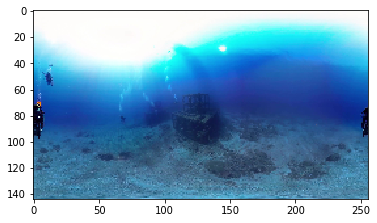

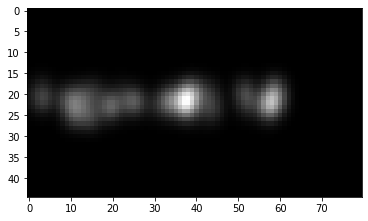

In [10]:
#DEBUG for class pakage
ds = 1
topic = 'diving'
t0 = 20.8
img, smap = salnet_datgen.get_sample(ds, topic, t0)
plt.imshow(img)
plt.figure()
plt.imshow(smap, cmap='gray')

In [6]:


def find_timeindex(t0, t_list):
    #TODO: find the nearest index in the given time list
    #INPUT: target time t0, time_list
    #OUTPUT: the index for t_list
    if t0 < t_list[0]: 
        return 0
    if t0 > t_list[-1]:
        return len(t_list) - 1
    for idx, _ in enumerate(t_list[1:]):
        if t_list[idx] > t0 and t_list[idx-1] <= t0:
            return idx
    print (t0, idx, t_list[idx], t_list[idx-1])
    raise #you should not get here
    
def get_saliencymap(saldat, ds, topic, t0, blur=True, resize=True):
    t_list = [item[0] for item in saldat]
    idx = find_timeindex(t0, t_list)
    _, _, salmap = saldat[idx]
    if blur==True:
        salmap = cv2.GaussianBlur(salmap,(TARGET_GAUSSIAN_BLUR,TARGET_GAUSSIAN_BLUR),0)
    if ds==3 and topic=='panel':
        h, w = salmap.shape
        d_roll = int(h * 0.08)
        salmap = np.roll(salmap, d_roll, axis=0)
    return salmap

def get_image(fps_dict, ds, topic, t0, resize=True):
    #handle special case when two names the same
    if ds==3 and topic=='diving':
        topic = 'diving2'
    fps = fps_dict[ds][topic]
    frameid = int(t0 * fps)
    frame_filepath = f'./dataset/pano-videos/frames/{topic}_{frameid:04d}.jpg'
    image = plt.imread(frame_filepath)
    if resize==True:
        image = cv2.resize(image, (TARGET_W, TARGET_H))
    return image, frame_filepath

def get_sample(saldict, fps_dict, ds, topic, t0):
    saliency_ds_lib.f_load_saldat_dict(saldict, ds, topic)
    saldat = saldict[saliency_ds_lib.f_create_key(ds, topic)]
    img, img_fp = get_image(fps_dict, ds, topic, t0)
    smap = get_saliencymap(saldat, ds, topic, t0)
    return img, smap

In [7]:
tdict

{1: ['paris', 'roller', 'venise', 'diving', 'timelapse'],
 2: ['0', '1', '2', '3', '4', '5part1', '6part1', '7', '8'],
 3: ['coaster2',
  'diving',
  'drive',
  'game',
  'landscape',
  'pacman',
  'ride',
  'sport']}

In [15]:
#TODO1: Create train set by getting frame at 4.0, 5.0,  ... timestamp
sal_ds = []
bpos, epos, step = 4, 60, 0.2
for ds in tdict:
    for topic in tdict[ds]:
        k = saliency_ds_lib.f_create_key(ds, topic)
        try:
            for t0 in np.arange(bpos, epos, step):
                img, smap = get_sample(saldict, fps_dict, ds, topic, t0)
                sal_ds.append((t0, img, smap))
        except Exception as e:
            print (f"Error at :{ds} - {topic} - {t0} - {e}")
            continue
pickle.dump(sal_ds, open('./dataset/pano-saliency/ds_dcnn_step002', 'wb'))

Error at :3 - coaster2 - 27.40000000000002 - [Errno 2] No such file or directory: './dataset/pano-videos/frames/coaster2_1644.jpg'


In [6]:
1+1

2

In [7]:
#TODO2: Create test set by getting frame at 4.5, 5.5,  ... timestamp
sal_ds_test = []
bpos, epos, step = 4.5, 60, 1.0
for ds in tdict:
    for topic in tdict[ds]:
        k = saliency_ds_lib.f_create_key(ds, topic)
        try:
            for t0 in np.arange(bpos, epos, step):
                img, smap = get_sample(saldict, fps_dict, ds, topic, t0)
                sal_ds_test.append(((ds, topic, t0), img, smap))
        except Exception as e:
            print (f"Error at :{ds} - {topic} - {t0} - {e}")
            continue
pickle.dump(sal_ds_test, open('./dataset/pano-saliency/ds_dcnn_test', 'wb'))

Error at :3 - coaster2 - 27.5 - [Errno 2] No such file or directory: './dataset/pano-videos/frames/coaster2_1650.jpg'


In [8]:
#TODO3: generate gt & pred saliency maps for video identification algorithm (matching eval)
#INPUT: 

#getting all timestamp from ./dataset/pano-saliency/ folder
tdict = header.topic_dict
time_dict = {1:{}, 2:{}, 3:{}}
for ds in tdict:
    for topic in tdict[ds]:
        dat = pickle.load(open(f'./dataset/pano-saliency/saliency_ds{ds}_topic{topic}', 'rb'))
        time_dict[ds][topic] = [item[0] for item in dat]
       

In [9]:
#
salpred_ds =[]
for ds in tdict:
    for topic in tdict[ds]:
        k = saliency_ds_lib.f_create_key(ds, topic)
        try:
            for t0 in time_dict[ds][topic]:
                img, smap = get_sample(saldict, fps_dict, ds, topic, t0)
                salpred_ds.append(((ds, topic, t0), img, smap))
        except Exception as e:
            print (f"Error at :{ds} - {topic} - {t0} - {e}")
            continue
pickle.dump(salpred_ds, open('./dataset/pano-saliency/ds_full', 'wb'))

Error at :1 - paris - 60.10000000000005 - [Errno 2] No such file or directory: './dataset/pano-videos/frames/paris_3602.jpg'
Error at :1 - roller - 62.14000000000006 - [Errno 2] No such file or directory: './dataset/pano-videos/frames/roller_1802.jpg'
Error at :1 - venise - 60.10000000000005 - [Errno 2] No such file or directory: './dataset/pano-videos/frames/venise_1502.jpg'
59.92000000000005 982 59.92000000000005 59.86000000000005
Error at :1 - diving - 59.92000000000005 - No active exception to reraise
Error at :1 - timelapse - 60.10000000000005 - [Errno 2] No such file or directory: './dataset/pano-videos/frames/timelapse_1803.jpg'
Error at :2 - 0 - 60.10000000000005 - [Errno 2] No such file or directory: './dataset/pano-videos/frames/0_1801.jpg'
Error at :2 - 1 - 60.16000000000005 - [Errno 2] No such file or directory: './dataset/pano-videos/frames/1_1802.jpg'
Error at :2 - 2 - 60.10000000000005 - [Errno 2] No such file or directory: './dataset/pano-videos/frames/2_1803.jpg'
Error

In [ ]:
pwd

In [ ]:
#pickle.dump(salpred_ds, open('./dataset/pano-saliency/ds_full', 'wb'))

In [ ]:
#SOME VISUALIZATION and DEBUGGING code

In [2]:
48 * 0.25

12.0